# FASE 4 - Analisis Espacial

# ALCANCE
* El objetivo de este script es complementar el modelo predictivo sobre las series de tiempo de alarmas relacionadas con el fluido electrico BOSS C.
* Se presenta un análisis DESCRIPTIVO espacial del fenómeno a nivel local.
 * Se identifican zonas dentro de las ciudades principales con mayor incidencia de códigos de alarmas y menores intervalos de tiempo entre la presentación del mismo código de alarma.

# Justificación
* El modelo de la fase 4 logra predecir la aparición de eventos que generan codigos de Alarmas para series independientes cuya única base de información es la historia del código de alarma en el Nodo.
* El modelo se puede enriquecer y complementar con anáisis espaciales aprovechando la relación geográfica entre los nodos en los que se reportán los códigos de alarma.

# Restricciones
* Debido a los problemas en la generación de información posterior al 19 de Febrero en la base de Netcool.  El siguiente análisis utiliza información de 10 días.
 * Esto limita la generación de conclusiones, sin embargo los procedimientos aquí utilizados puedes replicarse para una historia mayor permitiendo distingir patrones con mayor soporte.
 
# Recomendaciones

* La información de Netcool puede incluir (o cruzar) con el nombre del Nodo, dado que el campo NODOALIAS contiene diferentes formatos y no esta estandarizado (caracteres oculos, unión de nodos, simbolos +,- etc)
 * En el script se realizan varios procesos de transformación de la base pero aún quedan registros sin información geográfica.

* Repetir el proceso con mayor información realizando las siguientes comparaciones:
 * Contrastar estado el estado de los mapas en el tiempo
 * Realizar enfasis en las ciudades consideradas críticas para el negocio
 * Realizar análisis para códigos de alarmas específicos
 
# Análisis recomendados
* Con mayor cantidad de ejemplos en los datos se recomienda realizar los siguiente procesos de analítica espacial:
 * Identificación de clusters con problemas
 * Realizar análisis LISA por ubicación para identificar zonas en las que las alarmas tiene una relación espacial
 * Realizar el proceso One Hot Encoder para agregar información de clusters o municipios para enriquecer el modelo predictivo
 * Incluir información espacial (Ejemplo OpenStreetMaps o del IGAC para identificar relaciones de las fallas)
* Los anteriores análisis requiere un tiempo de análisis cercano a 1,5 meses.
* Con la información actual una gran cantidad de espacio no tiene eventos haciendo que los patrones se diluyan entre zonas sin generación de eventos. Poca fuerza en las relaciones.

# CONTENIDO
1. Importación de librerías
2. Carga de información
3. Descripción general, no estadística
4. Construcción de series de tiempo para calculo de intervalos temporales
5. Carga y preprocesamiento de información espacial
6. Mapas Coropléticos de coberturas con mayores alarmas
7. Mapas Coropléticos de coberturas con menores intervalos entre eventos
8. Patrones de puntos de eventos en ciudades principales, distribución por cordenadas
9. KDE (Estimación de densidad) por ciudad, permite identificar zonas e influencia con mayores eventos

# Importe de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import contextily
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
##Modelos
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from croston import croston
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from geopandas import GeoDataFrame
from pointpats import centrography
from datetime import timedelta

In [3]:
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", -1)

C:\Users\CristhianJohnatanIzq\AppData\Local\Temp\ipykernel_5992\2336295311.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Carga de Archivo

In [4]:
datosFinal=pd.read_csv('parcial.csv')

#### Clasificación de las 25 columnas

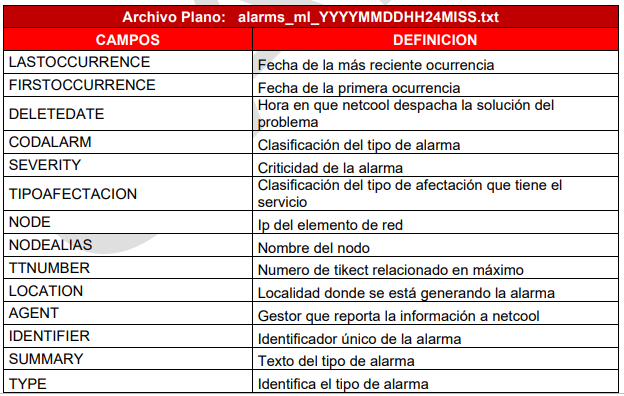
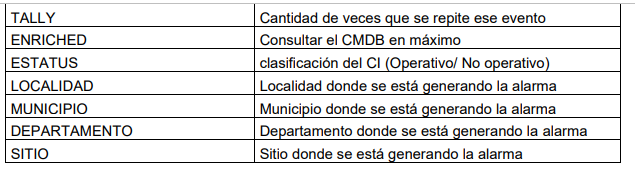

In [5]:
datosFinal.isnull().sum()/len(datosFinal)

Unnamed: 0         0.000000
IDENTIFIER         0.000000
NODE               0.000000
AGENT              0.000000
SEVERITY           0.000000
SUMMARY            0.000000
FIRSTOCCURRENCE    0.000000
LASTOCCURRENCE     0.000000
TYPE               0.000000
TALLY              0.000000
LOCATION           1.000000
DELETEDATE         0.407400
ENRICHED           0.525120
STATUS             0.543604
LOCALIDAD          1.000000
MUNICIPIO          0.546385
DEPARTAMENTO       0.546385
SITIO              0.546385
REGIONAL           0.546385
CODALARM           0.000000
TTNUMBER           0.997573
TECNOLOGIA         0.543604
LATITUD            1.000000
LONGITUD           1.000000
TIPOAFECTACION     0.495006
NODEALIAS          0.000000
CODALARM_2         0.000000
dtype: float64

### Val fechas

In [6]:
min_fecha=datosFinal['LASTOCCURRENCE'].min()
print(min_fecha)
max_fecha=datosFinal['LASTOCCURRENCE'].max()
print(max_fecha)

2022-02-07 23:31:32
2022-02-18 02:45:11


In [7]:
# Val identificador
datosFinal['NODE'].nunique()

7750

In [8]:
datosFinal['NODEALIAS'].nunique()

13197

In [9]:
maestroNodos=datosFinal[['NODE','NODEALIAS']].drop_duplicates()

### Analisis y formación Series de Tiempo

In [10]:
datosFinal[datosFinal['NODEALIAS']=='EDR']['IDENTIFIER'].value_counts()

172.21.150.53 | 2934 | Optical Nodes | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 2 | 5    104
5.17.19.225 | 969 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 4        1  
5.17.19.225 | 9332 | Power Supply | 1 | BOSSC | MTTrapd Probe on GSRCMDBTRI31 | 5 | 3       1  
Name: IDENTIFIER, dtype: int64

In [11]:
datosFinal['fecha']=pd.to_datetime(datosFinal['LASTOCCURRENCE']).dt.date

In [12]:
### quitar primer y último
datosFinal=datosFinal[datosFinal['fecha']!=datosFinal['fecha'].min()]
datosFinal=datosFinal[datosFinal['fecha']!=datosFinal['fecha'].max()]

In [13]:
datosFinal['CODALARM_2']=datosFinal['CODALARM_2'].astype(int)

In [14]:
resumenSeries=datosFinal.groupby(['NODEALIAS','CODALARM_2','fecha'])[['SEVERITY']].max().reset_index()

In [15]:
max_fecha=resumenSeries['fecha'].max()

In [16]:
## Validacion

In [17]:
resumenSeries['NODEALIAS'].value_counts()

AQL             60
RICAQLPS01      59
CHIUCI3DPS01    58
BOG2FEPS01      57
ZFI             57
                ..
RG5             1 
GRF             1 
GR21            1 
RGE             1 
BOG5B7011-12    1 
Name: NODEALIAS, Length: 13155, dtype: int64

## Frecuencias generales

### Series Nodo_CodAlarm

In [18]:
resumen_dias_alarma=resumenSeries[['NODEALIAS','CODALARM_2']].value_counts().to_frame()

In [19]:
resumen_dias_alarma.describe()

0
count  33129.000000
mean   1.895439    
std    2.056655    
min    1.000000    
25%    1.000000    
50%    1.000000    
75%    2.000000    
max    10.000000

In [20]:
resumen_dias_alarma_df=resumen_dias_alarma.value_counts().sort_index(ascending=False).to_frame()
resumen_dias_alarma_df.columns=['num_nodos_alarmCodes']

In [21]:
resumen_dias_alarma_df['part']=resumen_dias_alarma_df['num_nodos_alarmCodes']/resumen_dias_alarma_df['num_nodos_alarmCodes'].sum()
resumen_dias_alarma_df.columns=['num_nodos_alarmCodes','part']
resumen_dias_alarma_df.index.name='diasAlarm'
resumen_dias_alarma_df

num_nodos_alarmCodes      part
0                                 
10  1174                  0.035437
9   309                   0.009327
8   276                   0.008331
7   273                   0.008241
6   238                   0.007184
5   332                   0.010021
4   589                   0.017779
3   1566                  0.047270
2   5640                  0.170244
1   22732                 0.686166

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

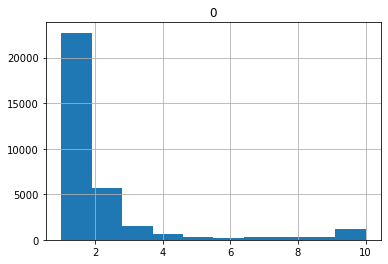

In [22]:
resumen_dias_alarma.hist()

In [23]:
resumen_dias_alarma_df['num_nodos_alarmCodes'].sum()

33129

### Nodo

In [24]:
resumenNodos=datosFinal.groupby(['NODEALIAS','fecha'])[['SEVERITY']].max().reset_index()

In [25]:
resumen_dias_nodo=resumenNodos[['NODEALIAS']].value_counts().to_frame()

In [26]:
resumen_dias_nodo.describe()

0
count  13155.000000
mean   2.874344    
std    2.858017    
min    1.000000    
25%    1.000000    
50%    2.000000    
75%    3.000000    
max    10.000000

In [27]:
resumen_dias_nodo_df=resumen_dias_nodo.value_counts().sort_index(ascending=False).to_frame()

In [28]:
resumen_dias_nodo_df['part']=resumen_dias_nodo_df[0]/resumen_dias_nodo_df[0].sum()
resumen_dias_nodo_df.columns=['num_nodos','part']

In [29]:
print("numero Nodos: ",len(resumen_dias_nodo))

numero Nodos:  13155


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

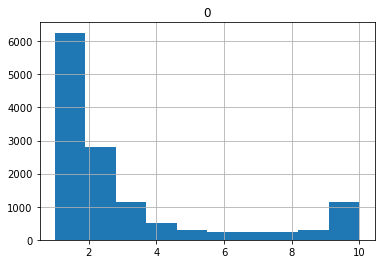

In [30]:
resumen_dias_nodo.hist()

# Preparacion Series

In [31]:
resumenSeries['SEVERITY']=resumenSeries['SEVERITY']+1

In [32]:
resumenSeries['key']=resumenSeries['NODEALIAS']+'---'+resumenSeries['CODALARM_2'].astype(str)

In [33]:
resumenSeries_pv=pd.pivot_table(resumenSeries, index=['fecha'], columns=['key'], values=['SEVERITY'])
resumenSeries_pv.columns = resumenSeries_pv.columns.droplevel()

In [34]:
dias_totales=len(resumenSeries_pv)
dias_totales

10

In [35]:
resumenSeries_pv.fillna(0, inplace=True)

In [36]:
resumenSeries_un=resumenSeries_pv.reset_index().melt(id_vars=['fecha'], var_name='key', value_name='SEVERITY')
resumenSeries_un.set_index('fecha',inplace=True)

#  Recurrencia de Eventos

In [37]:
resumenSeries_un=resumenSeries_un.sort_values(['key','fecha'])

In [38]:
resumenSeries_un_nonZero=resumenSeries_un.reset_index()
resumenSeries_un_nonZero=resumenSeries_un_nonZero[resumenSeries_un_nonZero['SEVERITY']!=0].reset_index()

In [39]:
resumenSeries_un_nonZero['sig_event']=resumenSeries_un_nonZero.groupby('key')['index'].shift(periods=-1)

In [40]:
resumenSeries_un_nonZero['dias_inter_event']=resumenSeries_un_nonZero['sig_event']-resumenSeries_un_nonZero['index']

In [41]:
resumenSeries_un_nonZero['dias_inter_event'].describe()

count    29665.000000
mean     1.777785    
std      1.563032    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      2.000000    
max      9.000000    
Name: dias_inter_event, dtype: float64

<AxesSubplot:>

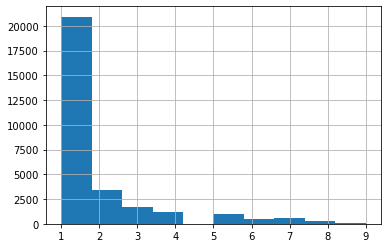

In [42]:
resumenSeries_un_nonZero['dias_inter_event'].hist()

In [43]:
resumenSeries_un_nonZero_df=resumenSeries_un_nonZero['dias_inter_event'].value_counts().to_frame()

In [44]:
resumenSeries_un_nonZero_df['part']=resumenSeries_un_nonZero['dias_inter_event'].value_counts()/len(resumenSeries_un_nonZero)

In [45]:
resumenSeries_un_nonZero[['NODO','code']] = resumenSeries_un_nonZero['key'].str.split('---',expand=True)

# Validacion Espacial

## Exploración
* Ordernar por area

In [46]:
import geopandas
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors

In [47]:
gdf1 = geopandas.read_file("espacial/OCTUBRE/COBERTURA_UNIF_OCTUBRE.shp")

In [48]:
#gdf1

In [49]:
gdf1['NODO'].nunique()

16918

In [50]:
len(gdf1)

18274

<AxesSubplot:>

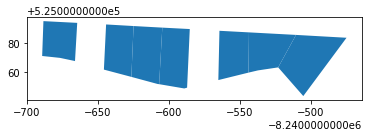

In [51]:
gdf1[gdf1['NODO']=='TOBG27'].plot()

In [52]:
gdf12 = gdf1.dissolve(by='NODO').reset_index()

<AxesSubplot:>

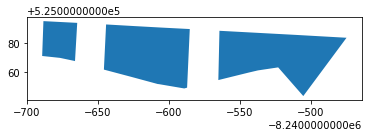

In [53]:
gdf12[gdf12['NODO']=='TOBG27'].plot()

-8240689.355806214 525042.9302334791 -8240474.731841618 525095.7629008082
-8795376.453206109 -471243.533192914 -7504024.960798843 1398041.1861394434


<AxesSubplot:>

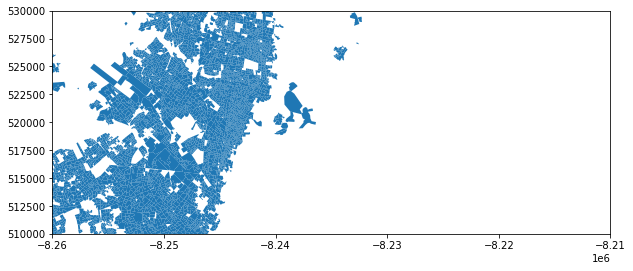

In [54]:
f, ax = plt.subplots(1, figsize=(10, 9))
minx, miny, maxx, maxy = gdf1[gdf1['NODO']=='TOBG27'].total_bounds
minx_t, miny_t, maxx_t, maxy_t = gdf1.total_bounds
print(minx, miny, maxx, maxy)
print(minx_t, miny_t, maxx_t, maxy_t)
ax.set_xlim(-8260000, -8210000)
ax.set_ylim(510000, 530000)
gdf12.plot(ax=ax, linewidth=1)

## CRUCE DE NODOS

In [55]:
NodosAlarmas=maestroNodos[['NODEALIAS']].drop_duplicates()
NodosAlarmas

NODEALIAS
0       SRL         
1       LCALC1PS01  
2       1CM         
4       TUNF3NPS01  
5       LCALC2PS01  
...            ...  
319085  RQU         
319087  MEDTBOPS02  
319110  MI3         
319218  BOGRQUPS01  
319261  BOG5C6023+24

[13197 rows x 1 columns]

In [56]:
NodosGeografia=gdf12[['NODO']].drop_duplicates()

In [57]:
NodosGeografia

NODO
0      01J
1      01S
2      02J
3      02S
4      03J
...    ...
16913  ZVD
16914  ZVG
16915  ZVS
16916  ZVT
16917  ZVZ

[16918 rows x 1 columns]

In [58]:
# Validar nodos en alarmas que no están en geografía

In [59]:
validacion=NodosAlarmas.merge(NodosGeografia, left_on='NODEALIAS', right_on='NODO', how='left')

In [60]:
len(validacion)

13197

In [61]:
validacion.isnull().sum()

NODEALIAS    0   
NODO         7334
dtype: int64

### Transformación
1. Quitar a la derecha del -
2. validar reemplazar + por coma
3. separar por comas
4. validar como compilar

In [62]:
validacion[(validacion['NODEALIAS'].str.contains("\-VIP"))&(validacion['NODO'].isnull())]
# -VIP
# - con espacios
# sig + por coma
# Palabra Nodo
# al quitar ps validar que el remanente tenga más 3 caracteres

NODEALIAS NODO
69     CALDJ3PS01-VIP  NaN
183    CARLT7PS01-VIP  NaN
244    CAR2BDPS01-VIP  NaN
256    MEDCF3PS01-VIP  NaN
260    PIERU2PS01-VIP  NaN
...               ...  ...
13012  LCARLEPS01-VIP  NaN
13046  MEDBYCPS01-VIP  NaN
13083  JAMPEHPS01-VIP  NaN
13085  JAMPVHPS02-VIP  NaN
13170  CAR5BDPS01-VIP  NaN

[554 rows x 2 columns]

In [63]:
### -VIP

In [64]:
validacion['trans1']=np.where((validacion['NODO'].isnull())&(validacion['NODEALIAS'].str.contains("\-VIP")), validacion['NODEALIAS'].str.split("\-VIP").str[0],validacion['NODEALIAS'])

In [65]:
# - espacio

In [66]:
validacion['trans2']=np.where((validacion['NODO'].isnull())&(validacion['trans1'].str.contains("\- ")), validacion['NODEALIAS'].str.split("\- ").str[0],validacion['trans1'])

In [67]:
# + por coma

In [68]:
validacion['trans3'] = validacion['trans2'].str.replace('+',',')

In [69]:
## Quitar palabra nodo,  previo pasar a mayuscula

In [70]:
validacion['trans4'] = validacion['trans3'].str.upper()

In [71]:
validacion['trans5'] = validacion['trans4'].str.replace('NODO ','')

In [72]:
# punto por coma

In [73]:
validacion['trans6'] = validacion['trans5'].str.replace('.',',')

In [74]:
## Quitar caracteres ocultos

In [75]:
validacion['trans7']=validacion['trans6'].str.replace('[^a-zA-Z0-9,]', '')

In [76]:
## Quitar ultima coma

In [77]:
validacion['trans8']=np.where((validacion['NODO'].isnull())&(validacion['trans7'].str[-1]==','), validacion['trans7'].str[:-1],validacion['trans7'])

In [78]:
# Separar por comas

In [79]:
validacion['trans9'] = validacion['trans8'].str.split(",")

In [80]:
#validacion

In [81]:
# trabajar con listas

In [82]:
validacion['trans10']=np.where((validacion['NODO'].isnull())&(len(validacion['trans9'])==0), validacion['NODEALIAS'],validacion['trans9'])

In [83]:
nodos_transf=pd.DataFrame(columns=["NODO_trans","NODEALIAS"])
for key,row in validacion[["trans10","NODEALIAS"]].iterrows():
    #print(row)
    aux_df=pd.DataFrame(row["trans10"],columns=['NODO_trans'])
    aux_df['NODEALIAS']=row["NODEALIAS"]
    #print(aux_df)
    nodos_transf=nodos_transf.append(aux_df)

In [84]:
##  Si blanco original

In [85]:
nodos_transf[nodos_transf['NODO_trans']=='']

NODO_trans     NODEALIAS
0             - CAMPO AZUL

In [86]:
nodos_transf['NODO_trans']=np.where(nodos_transf['NODO_trans']=='',nodos_transf['NODEALIAS'],nodos_transf['NODO_trans'])

In [87]:
### Cadena PS0X

In [88]:
nodos_transf['NODO_trans_2']=np.where(nodos_transf['NODO_trans'].str.contains("PS0"), nodos_transf['NODO_trans'].str[3:].str[:-4],nodos_transf['NODO_trans'])

### Cruzar con bases

In [89]:
nodos_transf_geo=nodos_transf.merge(gdf12, left_on='NODO_trans_2', right_on='NODO', how='left')

In [90]:
len(nodos_transf_geo)

13452

In [91]:
nodos_transf_geo = GeoDataFrame(nodos_transf_geo, crs=gdf12.crs.to_string(), geometry='geometry')

In [92]:
nodos_transf_geo_dis=nodos_transf_geo.dissolve(by='NODEALIAS')

In [93]:
## Seleccionar solo datos con información

In [94]:
print(" poligonos no cruzados", len(nodos_transf_geo_dis[nodos_transf_geo_dis['geometry']==None]))

 poligonos no cruzados 561


#### Cruzar tabla eventos original

In [95]:
resumenSeries_un_nonZero

index       fecha                  key  SEVERITY  sig_event  \
0      4       2022-02-12  - CAMPO AZUL---3229  1.0       9.0         
1      9       2022-02-17  - CAMPO AZUL---3229  1.0      NaN          
2      18      2022-02-16  001AC3FF5272---2934  6.0       19.0        
3      19      2022-02-17  001AC3FF5272---2934  6.0      NaN          
4      28      2022-02-16  012---1012           6.0      NaN          
...    ..             ...         ...           ...       ..          
62789  331243  2022-02-11  ZVZ---904            5.0      NaN          
62790  331253  2022-02-11  ZVZ---913            5.0      NaN          
62791  331263  2022-02-11  ZVZ---9332           5.0      NaN          
62792  331273  2022-02-11  ZVZ---969            5.0      NaN          
62793  331283  2022-02-11  ZVZ---975            5.0      NaN          

       dias_inter_event          NODO  code  
0      5.0               - CAMPO AZUL  3229  
1     NaN                - CAMPO AZUL  3229  
2      1.0               001AC3FF5272  2934  
3     NaN                001AC3FF5272  2934  
4     NaN                012           1012  
...    ..                ...            ...  
62789 NaN                ZVZ           904   
62790 NaN                ZVZ           913   
62791 NaN                ZVZ           9332  
62792 NaN                ZVZ           969   
62793 NaN                ZVZ           975   

[62794 rows x 8 columns]

## Dibujos mapas
* Eventos por poligono
* point patterns, puntos y desviación

In [96]:
resumenNodo=resumenSeries_un_nonZero['NODO'].value_counts().to_frame('#casos')

In [97]:
res_inter=resumenSeries_un_nonZero.groupby('NODO')[['dias_inter_event']].median()

In [98]:
resumenNodo=resumenNodo.join(resumenSeries_un_nonZero[resumenSeries_un_nonZero['dias_inter_event']>1].groupby('NODO')[['dias_inter_event']].median())

In [99]:
res_nodo_geo=geopandas.GeoDataFrame(resumenNodo.merge(nodos_transf_geo_dis, left_index=True,right_on='NODEALIAS', how='left'),crs=nodos_transf_geo_dis.crs)

In [100]:
res_nodo_geo[res_nodo_geo['dpto_cnmbr']=='BOGOTÁ, D.C.']["AREA"].unique()

array(['BOGOTA ORIENTE', 'BOGOTA SUR', None, 'BOGOTA OCCIDENTE',
       'BOGOTA NORTE'], dtype=object)

### Bogotá

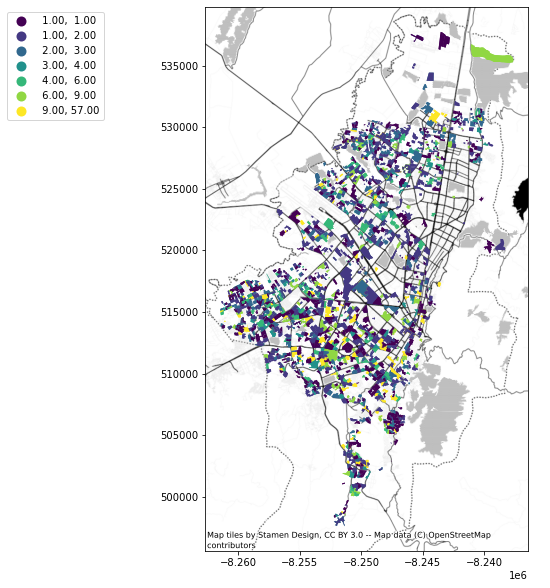

In [101]:
ax=res_nodo_geo[res_nodo_geo['dpto_cnmbr']=='BOGOTÁ, D.C.'].plot(column="#casos", scheme="quantiles", k=10, legend=True, figsize=(20,10),legend_kwds={'bbox_to_anchor': (-0.3,1)})
contextily.add_basemap(ax, crs=res_nodo_geo.crs.to_string(), source=contextily.providers.Stamen.TonerBackground)

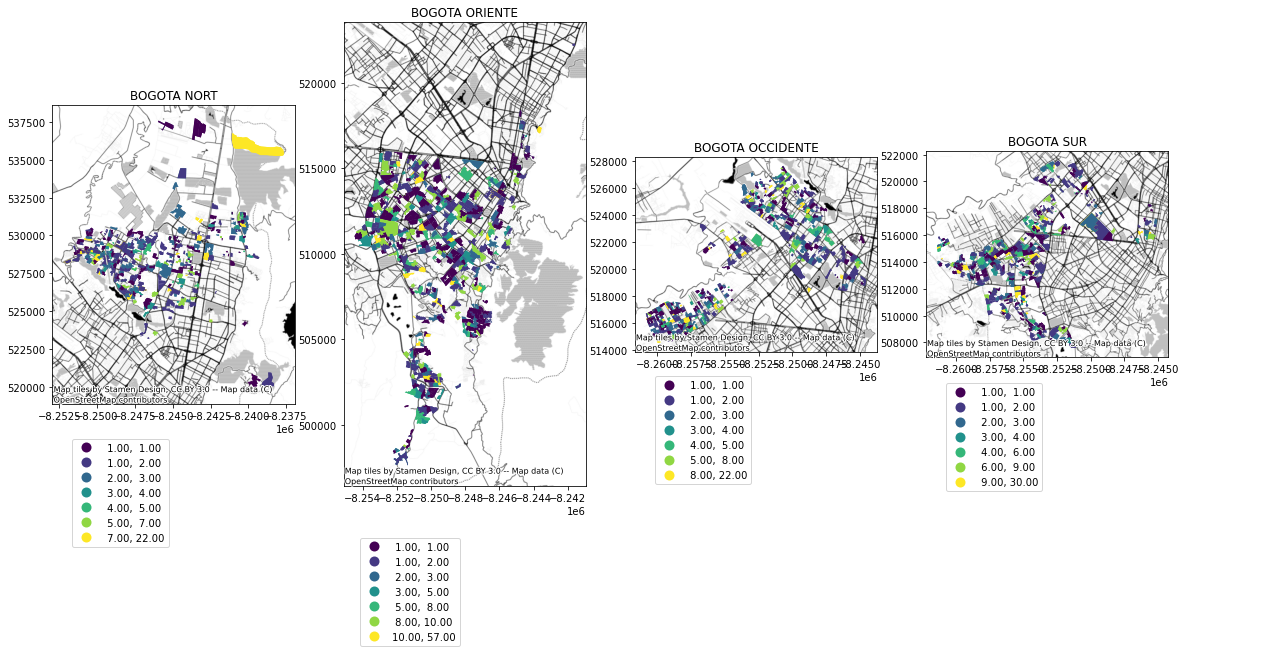

In [102]:
#, ,figsize=(20,20
f,ax = plt.subplots(1,4, figsize=(20,20))
#res_nodo_geo[res_nodo_geo['dpto_cnmbr']=='BOGOTÁ, D.C.'].plot(column="#casos", scheme="quantiles", k=10, legend=True, figsize=(20,10),legend_kwds={'bbox_to_anchor': (-0.5,1)}, ax=ax[0])
res_nodo_geo[(res_nodo_geo['dpto_cnmbr']=='BOGOTÁ, D.C.')&(res_nodo_geo['AREA']=='BOGOTA NORTE')].plot(column="#casos", scheme="quantiles", k=10, legend=True, figsize=(20,10),legend_kwds={'bbox_to_anchor': (0.5,-0.1,0,0)}, ax=ax[0])
ax[0].set_title("BOGOTA NORT")
res_nodo_geo[(res_nodo_geo['dpto_cnmbr']=='BOGOTÁ, D.C.')&(res_nodo_geo['AREA']=='BOGOTA ORIENTE')].plot(column="#casos", scheme="quantiles", k=10, legend=True, figsize=(20,10),legend_kwds={'bbox_to_anchor': (0.5,-0.1,0,0)}, ax=ax[1])
ax[1].set_title("BOGOTA ORIENTE")
res_nodo_geo[(res_nodo_geo['dpto_cnmbr']=='BOGOTÁ, D.C.')&(res_nodo_geo['AREA']=='BOGOTA OCCIDENTE')].plot(column="#casos", scheme="quantiles", k=10, legend=True, figsize=(20,10),legend_kwds={'bbox_to_anchor': (0.5,-0.1,0,0)}, ax=ax[2])
ax[2].set_title("BOGOTA OCCIDENTE")
res_nodo_geo[(res_nodo_geo['dpto_cnmbr']=='BOGOTÁ, D.C.')&(res_nodo_geo['AREA']=='BOGOTA SUR')].plot(column="#casos", scheme="quantiles", k=10, legend=True, figsize=(20,10),legend_kwds={'bbox_to_anchor': (0.5,-0.1,0,0)}, ax=ax[3])
ax[3].set_title("BOGOTA SUR")
contextily.add_basemap(ax[0], crs=res_nodo_geo.crs.to_string(), source=contextily.providers.Stamen.TonerBackground)
contextily.add_basemap(ax[1], crs=res_nodo_geo.crs.to_string(), source=contextily.providers.Stamen.TonerBackground)
contextily.add_basemap(ax[2], crs=res_nodo_geo.crs.to_string(), source=contextily.providers.Stamen.TonerBackground)
contextily.add_basemap(ax[3], crs=res_nodo_geo.crs.to_string(), source=contextily.providers.Stamen.TonerBackground)
#f.tight_layout()

## Medellín

In [103]:
res_nodo_geo['AREA'].unique()

array(['CUNMENAL', None, 'BOGOTA ORIENTE', 'BOGOTA NORTE', 'SANBOY',
       'EJE CAFETERO', 'COSTA SUR', 'CALI', 'COSTA NORTE', 'BOGOTA SUR',
       'BOGOTA OCCIDENTE', 'ANTCHO', 'MEDELLIN', 'TOLHUCA', 'VACANA'],
      dtype=object)

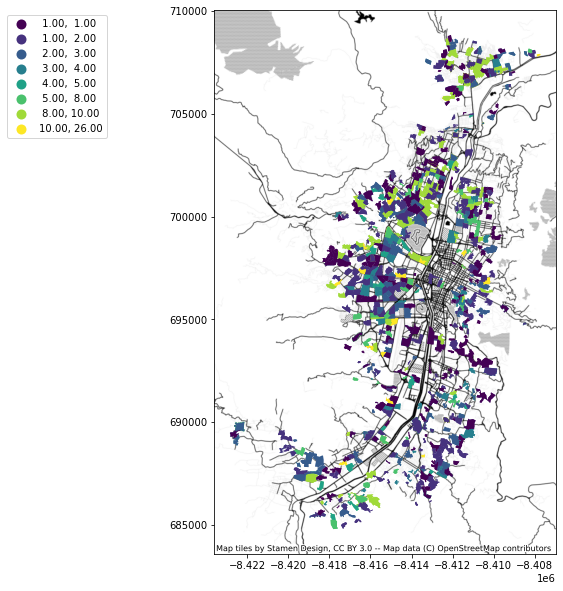

In [104]:
ax=res_nodo_geo[res_nodo_geo['AREA']=='MEDELLIN'].plot(column="#casos", scheme="quantiles", k=10, legend=True, figsize=(20,10),legend_kwds={'bbox_to_anchor': (-0.3,1)})
contextily.add_basemap(ax, crs=res_nodo_geo.crs.to_string(), source=contextily.providers.Stamen.TonerBackground)

# Cali

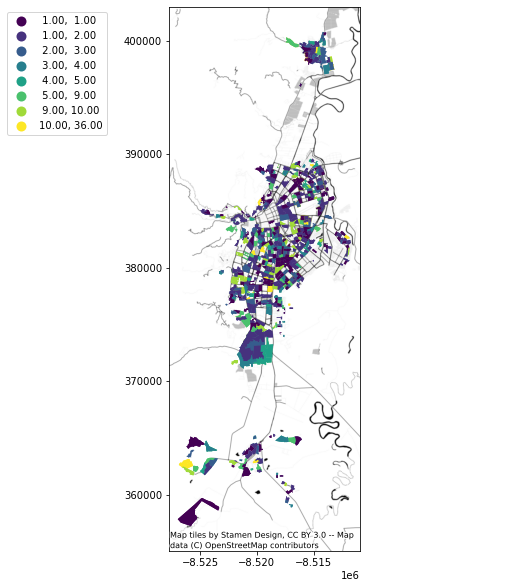

In [105]:
ax=res_nodo_geo[res_nodo_geo['AREA']=='CALI'].plot(column="#casos", scheme="quantiles", k=10, legend=True, figsize=(20,10),legend_kwds={'bbox_to_anchor': (-0.3,1)})
contextily.add_basemap(ax, crs=res_nodo_geo.crs.to_string(), source=contextily.providers.Stamen.TonerBackground)

# Bucaramanga

In [106]:
res_nodo_geo

#casos  dias_inter_event  \
NODEALIAS                                
AQL           60      2.0                
RICAQLPS01    59      2.0                
CHIUCI3DPS01  58      3.0                
BOG2FEPS01    57      2.0                
ZFI           57      2.0                
...           ..      ...                
RG5           1      NaN                 
GRF           1      NaN                 
GR21          1      NaN                 
RGE           1      NaN                 
BOG5B7011-12  1      NaN                 

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

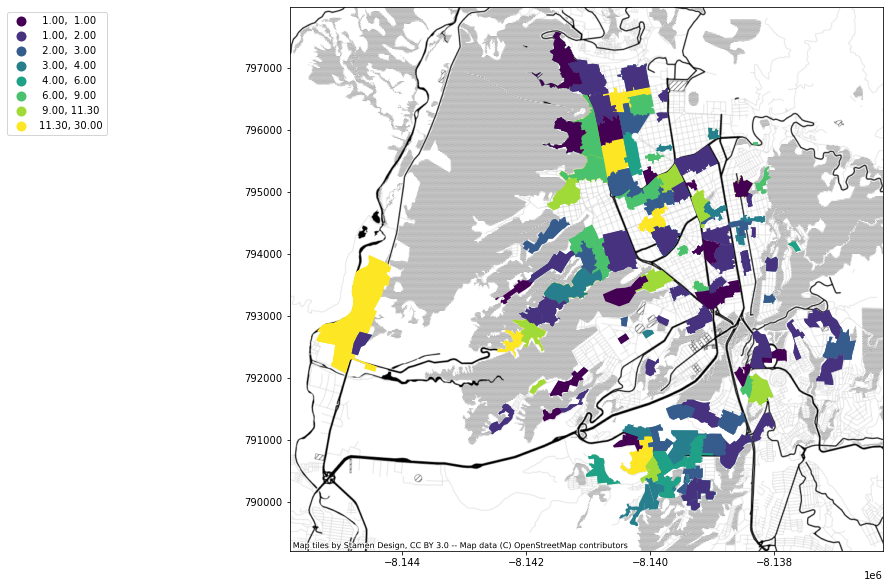

In [107]:
ax=res_nodo_geo[res_nodo_geo['mpio_cnmbr']=='BUCARAMANGA'].plot(column="#casos", scheme="quantiles", k=10, legend=True, figsize=(20,10),legend_kwds={'bbox_to_anchor': (-0.3,1)})
contextily.add_basemap(ax, crs=res_nodo_geo.crs.to_string(), source=contextily.providers.Stamen.TonerBackground)

## Intervalos de tiempo entre eventos

### Bogotá

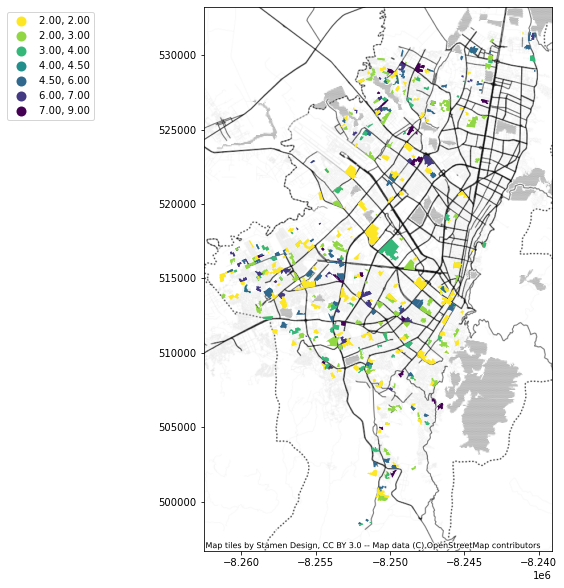

In [108]:
ax=res_nodo_geo[res_nodo_geo['dpto_cnmbr']=='BOGOTÁ, D.C.'].plot(column="dias_inter_event", scheme="quantiles", k=10, legend=True, figsize=(20,10),legend_kwds={'bbox_to_anchor': (-0.3,1)}, cmap='viridis_r')
contextily.add_basemap(ax, crs=res_nodo_geo.crs.to_string(), source=contextily.providers.Stamen.TonerBackground)

### Medellín

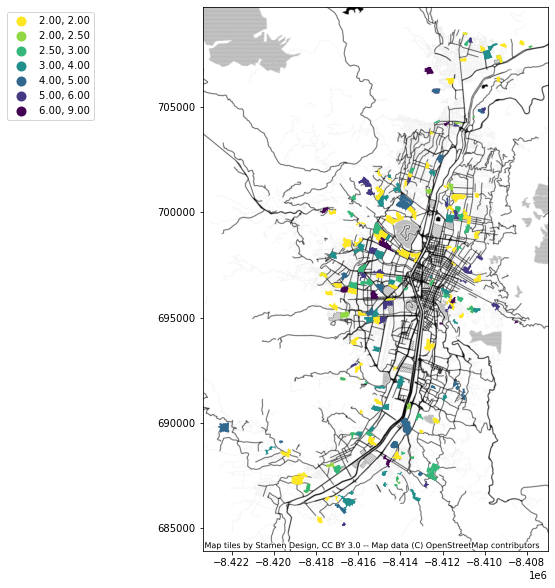

In [109]:
ax=res_nodo_geo[res_nodo_geo['AREA']=='MEDELLIN'].plot(column="dias_inter_event", scheme="quantiles", k=10, legend=True, figsize=(20,10),legend_kwds={'bbox_to_anchor': (-0.3,1)}, cmap='viridis_r')
contextily.add_basemap(ax, crs=res_nodo_geo.crs.to_string(), source=contextily.providers.Stamen.TonerBackground)

### Cali

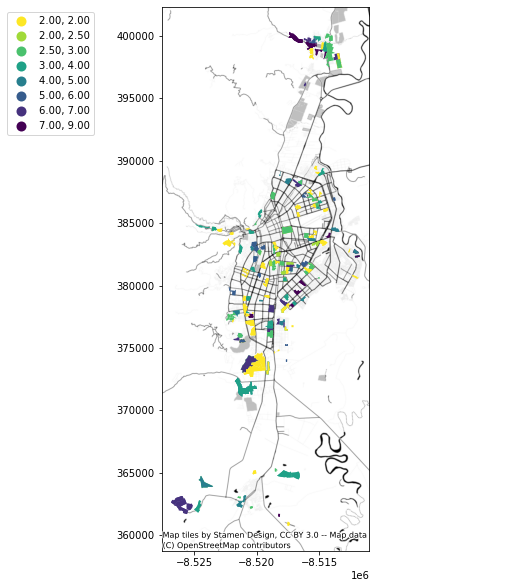

In [110]:
ax=res_nodo_geo[res_nodo_geo['AREA']=='CALI'].plot(column="dias_inter_event", scheme="quantiles", k=10, legend=True, figsize=(20,10),legend_kwds={'bbox_to_anchor': (-0.3,1)}, cmap='viridis_r')
contextily.add_basemap(ax, crs=res_nodo_geo.crs.to_string(), source=contextily.providers.Stamen.TonerBackground)

### Bucaramanga

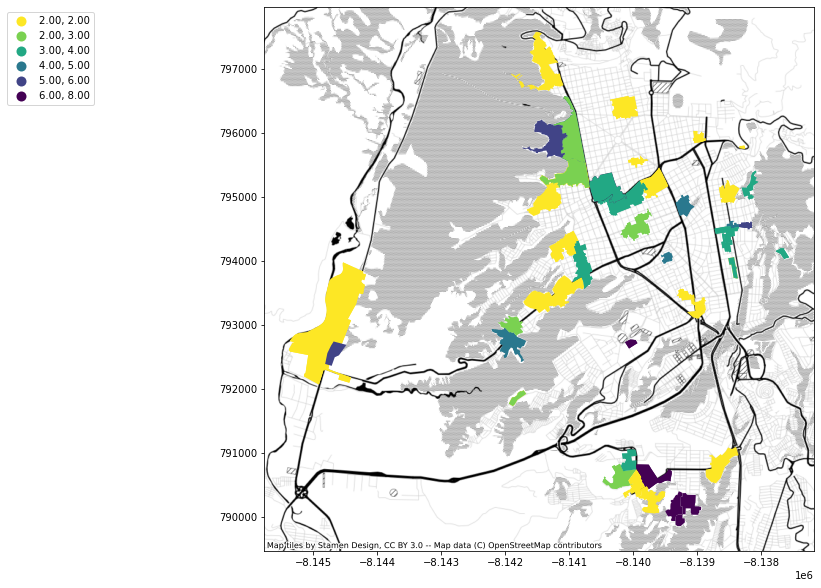

In [111]:
ax=res_nodo_geo[res_nodo_geo['mpio_cnmbr']=='BUCARAMANGA'].plot(column="dias_inter_event", scheme="quantiles", k=10, legend=True, figsize=(20,10),legend_kwds={'bbox_to_anchor': (-0.3,1)}, cmap='viridis_r')
contextily.add_basemap(ax, crs=res_nodo_geo.crs.to_string(), source=contextily.providers.Stamen.TonerBackground)

# point patterns

In [112]:
res_nodo_geo_point=geopandas.GeoDataFrame(resumenSeries_un_nonZero.merge(nodos_transf_geo_dis, left_on='NODO',right_index=True, how='left'), crs=nodos_transf_geo_dis.crs)

In [113]:
res_nodo_geo_point['centroid']=res_nodo_geo_point['geometry'].centroid

In [114]:
res_nodo_geo_point=res_nodo_geo_point.set_geometry('centroid')

In [115]:
res_nodo_geo_point['longitude']=res_nodo_geo_point['centroid'].x
res_nodo_geo_point['latitude']=res_nodo_geo_point['centroid'].y

In [116]:
#res_nodo_geo_point

In [117]:
mean_center = centrography.mean_center(res_nodo_geo_point[res_nodo_geo_point['dpto_cnmbr']=='BOGOTÁ, D.C.'][['longitude', 'latitude']])
med_center = centrography.euclidean_median(res_nodo_geo_point[res_nodo_geo_point['dpto_cnmbr']=='BOGOTÁ, D.C.'][['longitude', 'latitude']])

### Bogotá

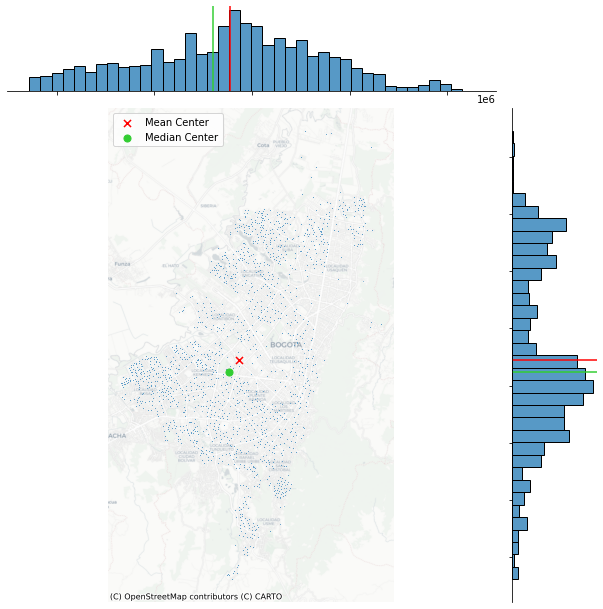

In [118]:
# Generate scatter plot
joint_axes = seaborn.jointplot(
    x='longitude', y='latitude', data=res_nodo_geo_point[res_nodo_geo_point['dpto_cnmbr']=='BOGOTÁ, D.C.'], s=0.75, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=50, label='Mean Center'
)
joint_axes.ax_marg_x.axvline(mean_center[0], color='red')
joint_axes.ax_marg_y.axhline(mean_center[1], color='red')
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=50, label='Median Center'
)
joint_axes.ax_marg_x.axvline(med_center[0], color='limegreen')
joint_axes.ax_marg_y.axhline(med_center[1], color='limegreen')
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(
    joint_axes.ax_joint, 
    source=contextily.providers.CartoDB.Positron
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

### Medellín

In [119]:
mean_center = centrography.mean_center(res_nodo_geo_point[res_nodo_geo_point['AREA']=='MEDELLIN'][['longitude', 'latitude']])
med_center = centrography.euclidean_median(res_nodo_geo_point[res_nodo_geo_point['AREA']=='MEDELLIN'][['longitude', 'latitude']])

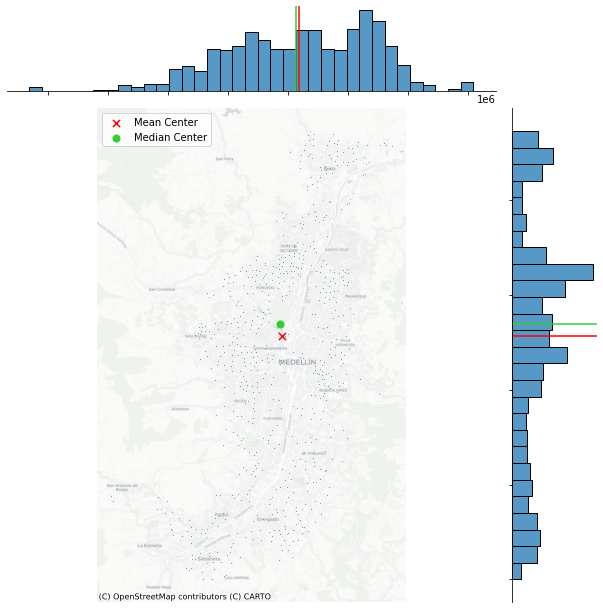

In [120]:
# Generate scatter plot
joint_axes = seaborn.jointplot(
    x='longitude', y='latitude', data=res_nodo_geo_point[res_nodo_geo_point['AREA']=='MEDELLIN'], s=0.75, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=50, label='Mean Center'
)
joint_axes.ax_marg_x.axvline(mean_center[0], color='red')
joint_axes.ax_marg_y.axhline(mean_center[1], color='red')
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=50, label='Median Center'
)
joint_axes.ax_marg_x.axvline(med_center[0], color='limegreen')
joint_axes.ax_marg_y.axhline(med_center[1], color='limegreen')
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(
    joint_axes.ax_joint, 
    source=contextily.providers.CartoDB.Positron
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

### Cali

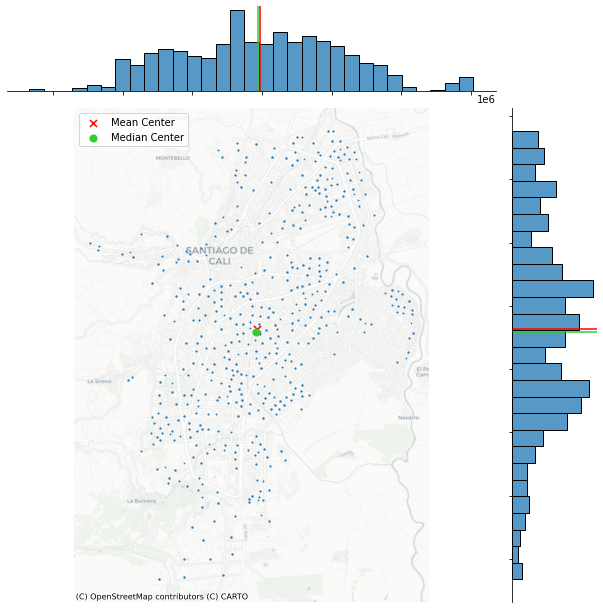

In [121]:
mean_center = centrography.mean_center(res_nodo_geo_point[res_nodo_geo_point['mpio_cnmbr']=='CALI'][['longitude', 'latitude']])
med_center = centrography.euclidean_median(res_nodo_geo_point[res_nodo_geo_point['mpio_cnmbr']=='CALI'][['longitude', 'latitude']])
# Generate scatter plot
joint_axes = seaborn.jointplot(
    x='longitude', y='latitude', data=res_nodo_geo_point[res_nodo_geo_point['mpio_cnmbr']=='CALI'], s=3, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=50, label='Mean Center'
)
joint_axes.ax_marg_x.axvline(mean_center[0], color='red')
joint_axes.ax_marg_y.axhline(mean_center[1], color='red')
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=50, label='Median Center'
)
joint_axes.ax_marg_x.axvline(med_center[0], color='limegreen')
joint_axes.ax_marg_y.axhline(med_center[1], color='limegreen')
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(
    joint_axes.ax_joint, 
    source=contextily.providers.CartoDB.Positron
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

### Buraramanga

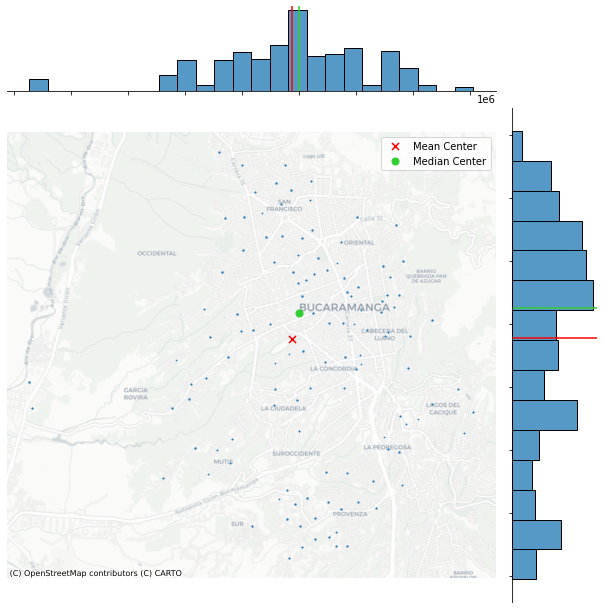

In [122]:
mean_center = centrography.mean_center(res_nodo_geo_point[res_nodo_geo_point['mpio_cnmbr']=='BUCARAMANGA'][['longitude', 'latitude']])
med_center = centrography.euclidean_median(res_nodo_geo_point[res_nodo_geo_point['mpio_cnmbr']=='BUCARAMANGA'][['longitude', 'latitude']])
# Generate scatter plot
joint_axes = seaborn.jointplot(
    x='longitude', y='latitude', data=res_nodo_geo_point[res_nodo_geo_point['mpio_cnmbr']=='BUCARAMANGA'], s=3, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=50, label='Mean Center'
)
joint_axes.ax_marg_x.axvline(mean_center[0], color='red')
joint_axes.ax_marg_y.axhline(mean_center[1], color='red')
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=50, label='Median Center'
)
joint_axes.ax_marg_x.axvline(med_center[0], color='limegreen')
joint_axes.ax_marg_y.axhline(med_center[1], color='limegreen')
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(
    joint_axes.ax_joint, 
    source=contextily.providers.CartoDB.Positron
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

### Varianzas Espaciales

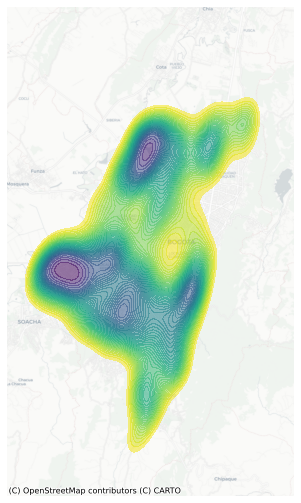

In [123]:
f, ax = plt.subplots(1, figsize=(9, 9))
seaborn.kdeplot(
    res_nodo_geo_point[res_nodo_geo_point['dpto_cnmbr']=='BOGOTÁ, D.C.']['longitude'], 
    res_nodo_geo_point[res_nodo_geo_point['dpto_cnmbr']=='BOGOTÁ, D.C.']['latitude'],
    n_levels=50, 
    shade=True,
    alpha=0.55, 
    cmap='viridis_r'
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()

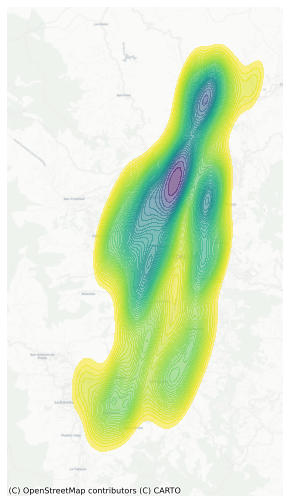

In [124]:
## Desviación
f, ax = plt.subplots(1, figsize=(9, 9))
seaborn.kdeplot(
    res_nodo_geo_point[res_nodo_geo_point['AREA']=='MEDELLIN']['longitude'], 
    res_nodo_geo_point[res_nodo_geo_point['AREA']=='MEDELLIN']['latitude'],
    n_levels=50, 
    shade=True,
    alpha=0.55, 
    cmap='viridis_r'
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()

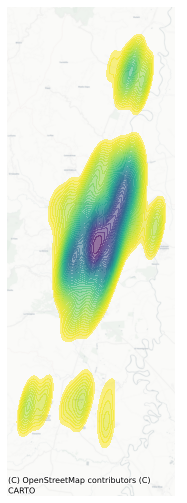

In [125]:
## Desviación
f, ax = plt.subplots(1, figsize=(9, 9))
seaborn.kdeplot(
    res_nodo_geo_point[res_nodo_geo_point['AREA']=='CALI']['longitude'], 
    res_nodo_geo_point[res_nodo_geo_point['AREA']=='CALI']['latitude'],
    n_levels=50, 
    shade=True,
    alpha=0.55, 
    cmap='viridis_r'
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()

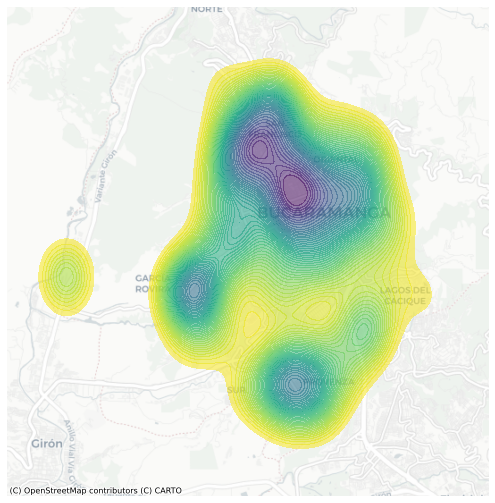

In [126]:
## Desviación
f, ax = plt.subplots(1, figsize=(9, 9))
seaborn.kdeplot(
    res_nodo_geo_point[res_nodo_geo_point['mpio_cnmbr']=='BUCARAMANGA']['longitude'], 
    res_nodo_geo_point[res_nodo_geo_point['mpio_cnmbr']=='BUCARAMANGA']['latitude'],
    n_levels=50, 
    shade=True,
    alpha=0.55, 
    cmap='viridis_r'
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()

###  Cruzar con info Alarmas

In [127]:
resumen_dias_nodo=resumen_dias_nodo.reset_index()

In [128]:
resumen_dias_nodo.columns=['NODO','dias_A']

In [129]:
gdf1.set_index('NODO',inplace=True)

In [130]:
analisisNodos = geopandas.GeoDataFrame(gdf1.join(resumen_dias_nodo.set_index('NODO')[['dias_A']]), crs=gdf1.crs)

In [131]:
analisisNodos['dias_A']=np.where(analisisNodos['dias_A'].isnull(),0,analisisNodos['dias_A'])

In [132]:
points = analisisNodos.copy() 
points['geometry'] = points['geometry'].centroid

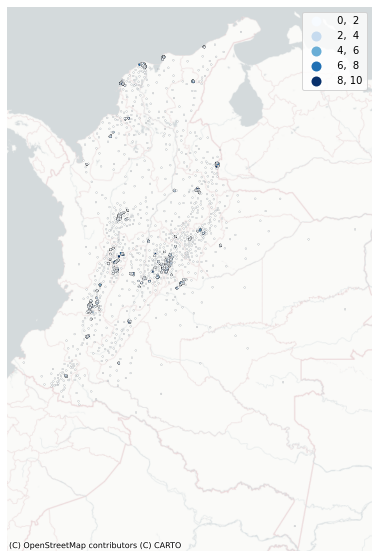

In [133]:
ax = points.plot(
    column='dias_A',          # Data to plot
    scheme='equal_interval',          # Classification scheme
    cmap='Blues',                # Color palette
    edgecolor='k',               # Borderline color
    linewidth=0.1,               # Borderline width
    markersize=3,
    legend=True,                 # Add legend
    legend_kwds={'fmt':'{:.0f}'} # Remove decimals in legend (for legibility)
    ,figsize=(10, 10)
)
ax.set_axis_off();

contextily.add_basemap(ax, 
                       crs=points.crs, 
                       #source=contextily.providers.Stamen.TerrainBackground
                       source=contextily.providers.CartoDB.PositronNoLabels
                      )

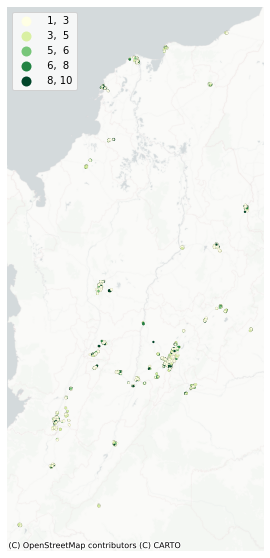

In [134]:
ax = points[points['dias_A']>0].plot(
    column='dias_A',          # Data to plot
    scheme='equal_interval',          # Classification scheme
    cmap='YlGn',                # Color palette
    edgecolor='k',
    markersize=5, # Borderline color
    linewidth=0.03,               # Borderline width
    legend=True,                 # Add legend
    legend_kwds={'fmt':'{:.0f}'} # Remove decimals in legend (for legibility)
    ,figsize=(10, 10)
)
ax.set_axis_off();

contextily.add_basemap(ax, 
                       crs=points.crs, 
                       #source=contextily.providers.Stamen.TerrainBackground
                       source=contextily.providers.CartoDB.PositronNoLabels
                      )

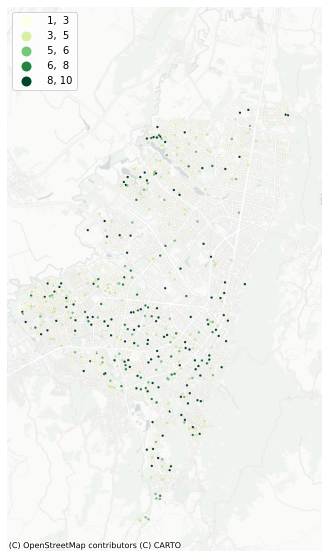

In [135]:
#DIVISION
ax = points[(points['dias_A']>0)&(points['dpto_cnmbr']=='BOGOTÁ, D.C.')].plot(
    column='dias_A',          # Data to plot
    scheme='equal_interval',          # Classification scheme
    cmap='YlGn',                # Color palette
    edgecolor='k',               # Borderline color
    linewidth=0.03,               # Borderline width
    markersize=5,
    legend=True,                 # Add legend
    legend_kwds={'fmt':'{:.0f}'} # Remove decimals in legend (for legibility)
    ,figsize=(10, 10)
)
ax.set_axis_off();

contextily.add_basemap(ax, 
                       crs=points.crs, 
                       #source=contextily.providers.Stamen.TerrainBackground
                       source=contextily.providers.CartoDB.PositronNoLabels
                      )

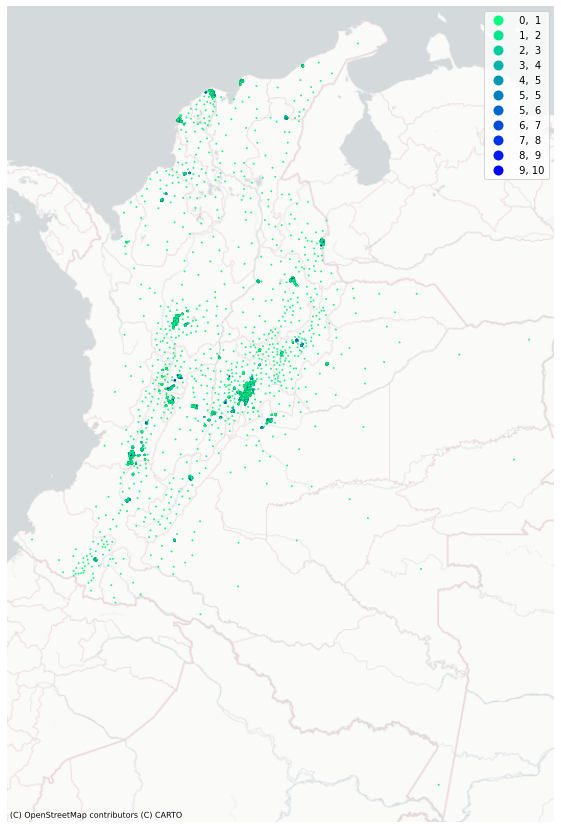

In [136]:
#DIVISION
ax = points.plot(
    column='dias_A',          # Data to plot
    scheme='equal_interval',          # Classification scheme
    k=11,
    cmap='winter_r',                # Color palette
    edgecolor='k',               # Borderline color
    linewidth=0.03,
    markersize=3,# Borderline width
    legend=True,                 # Add legend
    legend_kwds={'fmt':'{:.0f}'} # Remove decimals in legend (for legibility)
    ,figsize=(15, 15)
)
ax.set_axis_off();

contextily.add_basemap(ax, 
                       crs=points.crs, 
                       #source=contextily.providers.Stamen.TerrainBackground
                       source=contextily.providers.CartoDB.PositronNoLabels
                       #source=contextily.providers.Stamen.TonerLabels
                      )

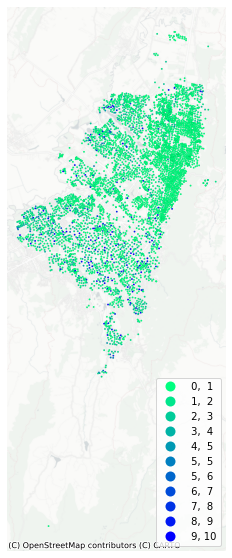

In [137]:
#DIVISION
ax = points[points['dpto_cnmbr']=='BOGOTÁ, D.C.'].plot(
    column='dias_A',          # Data to plot
    scheme='equal_interval',          # Classification scheme
    k=11,
    cmap='winter_r',                # Color palette
    edgecolor='k',               # Borderline color
    linewidth=0.03,
    markersize=3,# Borderline width
    legend=True,                 # Add legend
    legend_kwds={'fmt':'{:.0f}'} # Remove decimals in legend (for legibility)
    ,figsize=(10, 10)
)
ax.set_axis_off();

contextily.add_basemap(ax, 
                       crs=points.crs, 
                       #source=contextily.providers.Stamen.TerrainBackground
                       source=contextily.providers.CartoDB.PositronNoLabels
                       #source=contextily.providers.Stamen.TonerLabels
                      )

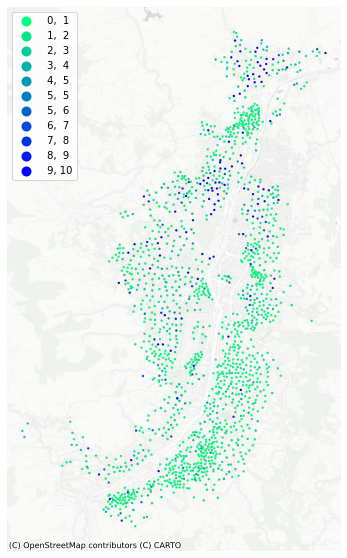

In [138]:
#DIVISION
ax = points[points['AREA']=='MEDELLIN'].plot(
    column='dias_A',          # Data to plot
    scheme='equal_interval',          # Classification scheme
    k=11,
    cmap='winter_r',                # Color palette
    edgecolor='k',               # Borderline color
    linewidth=0.03,
    markersize=5,# Borderline width
    legend=True,                 # Add legend
    legend_kwds={'fmt':'{:.0f}'} # Remove decimals in legend (for legibility)
    ,figsize=(10, 10)
)
ax.set_axis_off();

contextily.add_basemap(ax, 
                       crs=points.crs,                        
                       source=contextily.providers.CartoDB.PositronNoLabels                       
                      )

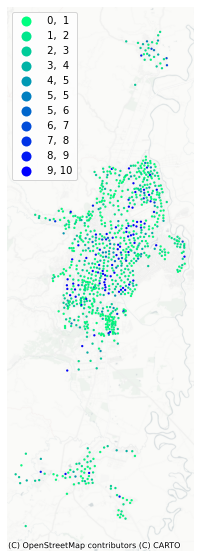

In [139]:
#DIVISION
ax = points[points['AREA']=='CALI'].plot(
    column='dias_A',          # Data to plot
    scheme='equal_interval',          # Classification scheme
    k=11,
    cmap='winter_r',                # Color palette
    edgecolor='k',               # Borderline color
    linewidth=0.03,
    markersize=5,# Borderline width
    legend=True,                 # Add legend
    legend_kwds={'fmt':'{:.0f}'} # Remove decimals in legend (for legibility)
    ,figsize=(10, 10)
)
ax.set_axis_off();

contextily.add_basemap(ax, 
                       crs=points.crs,                        
                       source=contextily.providers.CartoDB.PositronNoLabels                       
                      )

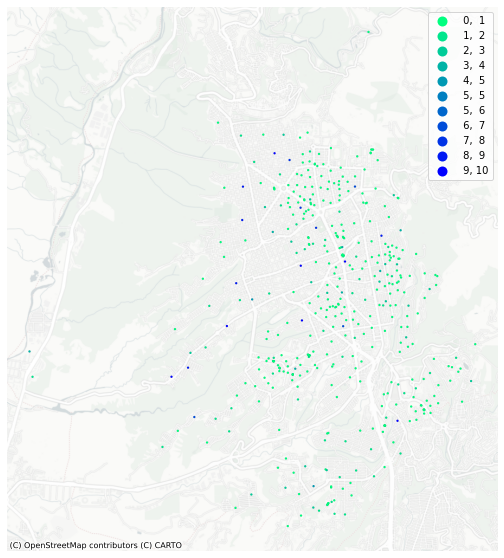

In [140]:
#DIVISION
ax = points[points['mpio_cnmbr']=='BUCARAMANGA'].plot(
    column='dias_A',          # Data to plot
    scheme='equal_interval',          # Classification scheme
    k=11,
    cmap='winter_r',                # Color palette
    edgecolor='k',               # Borderline color
    linewidth=0.03,
    markersize=5,# Borderline width
    legend=True,                 # Add legend
    legend_kwds={'fmt':'{:.0f}'} # Remove decimals in legend (for legibility)
    ,figsize=(10, 10)
)
ax.set_axis_off();

contextily.add_basemap(ax, 
                       crs=points.crs,                        
                       source=contextily.providers.CartoDB.PositronNoLabels                       
                      )

### Distribución de tiempo de ocurrencia

In [141]:
analisisNodos_ocurrencia = geopandas.GeoDataFrame(gdf1.join(resumenSeries_un_nonZero.set_index('NODO')[['dias_inter_event']]), crs=gdf1.crs)

In [142]:
analisisNodos_ocurrencia['dias_inter_event']=np.where(analisisNodos_ocurrencia['dias_inter_event'].isnull(),0,analisisNodos_ocurrencia['dias_inter_event'])

In [143]:
# copy GeoDataFrame
points_ocurrencia = analisisNodos_ocurrencia.copy()
# change geometry 
points_ocurrencia['geometry'] = points_ocurrencia['geometry'].centroid

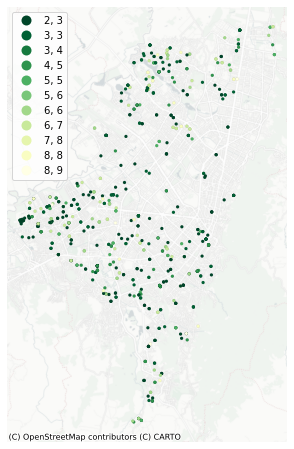

In [144]:
#DIVISION
ax = points_ocurrencia[(points_ocurrencia['dpto_cnmbr']=='BOGOTÁ, D.C.')&(points_ocurrencia['dias_inter_event']>=2)].plot(
    column='dias_inter_event',          # Data to plot
    scheme='equal_interval',          # Classification scheme
    k=11,
    cmap='YlGn_r',                # Color palette
    edgecolor='k',               # Borderline color
    linewidth=0.03,
    markersize=10,# Borderline width
    legend=True,                 # Add legend
    legend_kwds={'fmt':'{:.0f}'} # Remove decimals in legend (for legibility)
    ,figsize=(8, 8)
)
ax.set_axis_off();

contextily.add_basemap(ax, 
                       crs=points.crs,                        
                       source=contextily.providers.CartoDB.PositronNoLabels                       
                      )

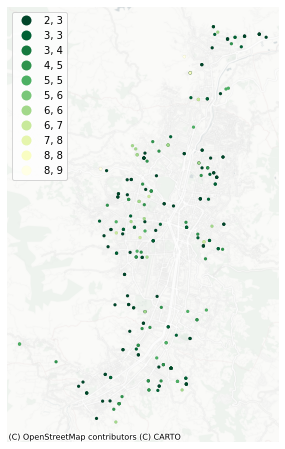

In [145]:
#DIVISION
ax = points_ocurrencia[(points_ocurrencia['AREA']=='MEDELLIN')&(points_ocurrencia['dias_inter_event']>=2)].plot(
    column='dias_inter_event',          # Data to plot
    scheme='equal_interval',          # Classification scheme
    k=11,
    cmap='YlGn_r',                # Color palette
    edgecolor='k',               # Borderline color
    linewidth=0.03,
    markersize=10,# Borderline width
    legend=True,                 # Add legend
    legend_kwds={'fmt':'{:.0f}'} # Remove decimals in legend (for legibility)
    ,figsize=(8, 8)
)
ax.set_axis_off();

contextily.add_basemap(ax, 
                       crs=points.crs,                        
                       source=contextily.providers.CartoDB.PositronNoLabels                       
                      )

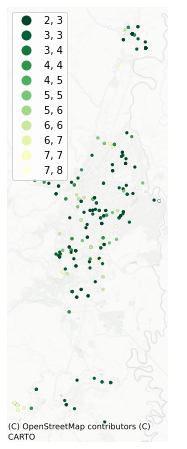

In [146]:
#DIVISION
ax = points_ocurrencia[(points_ocurrencia['AREA']=='CALI')&(points_ocurrencia['dias_inter_event']>=2)].plot(
    column='dias_inter_event',          # Data to plot
    scheme='equal_interval',          # Classification scheme
    k=11,
    cmap='YlGn_r',                # Color palette
    edgecolor='k',               # Borderline color
    linewidth=0.03,
    markersize=10,# Borderline width
    legend=True,                 # Add legend
    legend_kwds={'fmt':'{:.0f}'} # Remove decimals in legend (for legibility)
    ,figsize=(8, 8)
)
ax.set_axis_off();

contextily.add_basemap(ax, 
                       crs=points.crs,                        
                       source=contextily.providers.CartoDB.PositronNoLabels                       
                      )

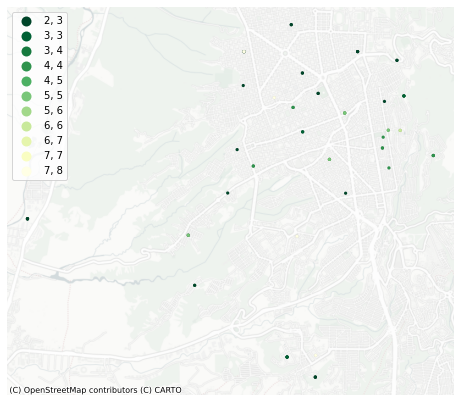

In [147]:
#DIVISION
ax = points_ocurrencia[(points_ocurrencia['mpio_cnmbr']=='BUCARAMANGA')&(points_ocurrencia['dias_inter_event']>=2)].plot(
    column='dias_inter_event',          # Data to plot
    scheme='equal_interval',          # Classification scheme
    k=11,
    cmap='YlGn_r',                # Color palette
    edgecolor='k',               # Borderline color
    linewidth=0.03,
    markersize=10,# Borderline width
    legend=True,                 # Add legend
    legend_kwds={'fmt':'{:.0f}'} # Remove decimals in legend (for legibility)
    ,figsize=(8, 8)
)
ax.set_axis_off();

contextily.add_basemap(ax, 
                       crs=points.crs,                        
                       source=contextily.providers.CartoDB.PositronNoLabels                       
                      )